In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
chars =  ['.'] + sorted(list(set(''.join(words)))) 
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for s, i in stoi.items()}

In [5]:
# dataset
context_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*context_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:]+[ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
emb_dim = 10
hid_dim = 200
vocab_size = len(itos)

In [7]:
C = torch.randn((vocab_size,emb_dim))
W1 = torch.randn((context_size*emb_dim, hid_dim))  * ((5/3) / ((context_size*emb_dim)**0.5))
# b1 = torch.randn(hid_dim)                 * 0.01 # not used since batch norm subtracts it
W2 = torch.randn((hid_dim, vocab_size))            * 0.01
b2 = torch.randn(vocab_size)    * 0

# batchNorm parameters
bngain = torch.ones((1, hid_dim))
bnbias = torch.zeros((1, hid_dim))
bnmean_running = torch.zeros((1, hid_dim))
bnstd_running = torch.ones((1, hid_dim))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [8]:
sum(p.nelement() for p in parameters)

12097

In [9]:
epochs = 200000
et = epochs/10
lr = 0.1
batch_size = 32

In [10]:
lossi=[]
stepi=[]
ep = 0

In [11]:
%%time
# training
for i in range(epochs):
    # mini batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))

    #forward 
    emb = C[Xtr[ix]]
    emb_out = emb.view(emb.shape[0], -1)
    # first linear layer
    preact = emb_out @ W1 #  + b1 not used in batch norm
    # batch norm
    bnmeani = preact.mean(0, keepdim=True)
    bnstdi = preact.std(0, keepdim=True)
    preact = (preact - bnmeani)/bnstdi
    preact = bngain * preact + bnbias
    # buffers
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # activation
    h = torch.tanh(preact)
    # second linear layer
    logits = h @ W2 + b2

    # loss
    loss = F.cross_entropy(logits, Ytr[ix])

    if i > 100000:
        lr = 0.01
        
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats 
    stepi.append(ep)
    lossi.append(loss.log10().item())
    ep+=1

    if i%et==0:
        print(f'{i}/{epochs}:  {loss.item():.4f}')
    # break

0/200000:  3.2759
20000/200000:  2.0640
40000/200000:  2.5796
60000/200000:  2.0423
80000/200000:  2.1228
100000/200000:  1.7954
120000/200000:  1.8527
140000/200000:  2.1160
160000/200000:  2.3326
180000/200000:  1.9334
CPU times: user 4min 36s, sys: 1.92 s, total: 4min 38s
Wall time: 2min 19s


In [11]:
# # logits[0]
# plt.hist(h.view(-1).tolist(), 50);


In [37]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [42]:
# calibrate the batch norm at the end of the training
# or use running_mean and running_std of batchnorm while training 
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     preact = embcat @ W1 + b1
#     bnmean = preact.mean(0, keepdim=True)
#     bnstd = preact.std(0, keepdim=True)
bnmean = bnmean_running
bnstd = bnstd_running

In [55]:
%%time
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    emb_out = emb.view(emb.shape[0], -1)
    print(emb_out.shape)
    preact = emb_out @ W1
    # preact = (preact - preact.mean(0, keepdim=True))/preact.std(0, keepdim=True)
    preact = (preact - bnmean)/bnstd
    preact = bngain * preact + bnbias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

torch.Size([182580, 30])
2.071359872817993
torch.Size([22767, 30])
2.1140968799591064
torch.Size([22799, 30])
2.1186838150024414
CPU times: user 416 ms, sys: 128 ms, total: 544 ms
Wall time: 272 ms


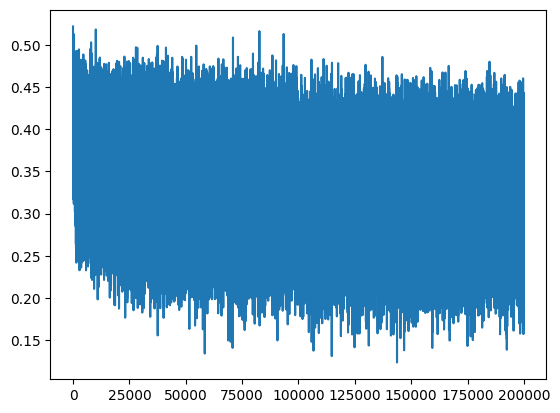

In [47]:
plt.plot(stepi, lossi)

In [64]:
for i in range(10):
    context = [0]*context_size
    output = []
    while True:
        emb = C[context]
        emb_out = emb.view(1, -1)
        preact = emb_out @ W1
        preact = (preact - bnmean)/bnstd
        preact = bngain * preact + bnbias
        h = torch.tanh(preact)
        logits = h @ W2 + b2
        p = torch.softmax(logits, 1)
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        output.append(itos[ix])
        context = context[1:]+[ix]
        if ix == 0:
            break
    print(''.join(output))

zyren.
camei.
ambriyah.
aton.
wila.
rajtevon.
bettilynnessa.
amarystan.
juan.
jaisleiya.
